# Periodgram Smoothing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Primer boludeo con AR(1) para ganar feeling

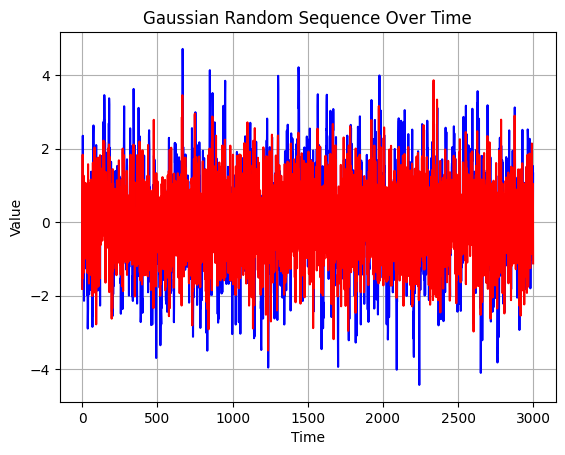

In [84]:
total_points = 3000

A = 0.7
den = [1, -A]
num = [1]
ar_sys = signal.TransferFunction(num, den, dt = 1)

mean = 0
std = 1
e = np.random.normal(mean, std, total_points)

tout, yout = signal.dlsim(ar_sys, e)

plt.plot(tout, yout, linestyle='-', color='b')
plt.plot(tout, e, linestyle='-', color='r')
plt.title('Gaussian Random Sequence Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()



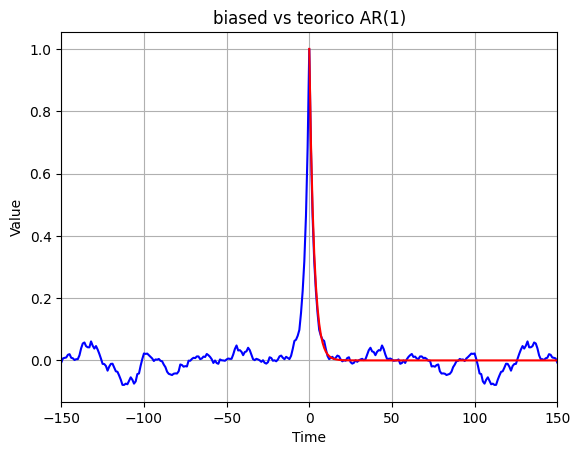

In [105]:
corr = np.correlate(yout[:, 0], yout[:, 0], mode = 'full')
ryy_biased = corr / total_points
ryy_unbiased_normalized = np.array([corr[x] / (total_points - np.abs(total_points-1 - x)) for x in range(0, len(corr))]) /  ryy_biased[total_points-1]
ryy_biased_normalized = ryy_biased /  ryy_biased[total_points-1]
n = np.arange(0, total_points+1)
ryy_teo = pow(A, n)

plt.plot(np.arange(-(total_points-1), total_points), ryy_biased_normalized, linestyle='-', color='b')
#plt.plot(np.arange(-(total_points-1), total_points), ryy_unbiased_normalized, linestyle='-', color='g')
plt.plot(n, ryy_teo, linestyle='-', color='r')
plt.title('biased vs teorico AR(1)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.xlim(-150, 150)
plt.show()

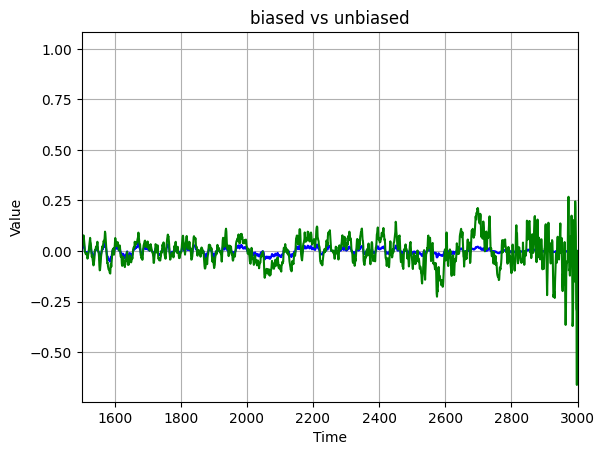

In [104]:
plt.plot(np.arange(-(total_points-1), total_points), ryy_biased_normalized, linestyle='-', color='b')
plt.plot(np.arange(-(total_points-1), total_points), ryy_unbiased_normalized, linestyle='-', color='g')
plt.title('biased vs unbiased')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.xlim(1500, 3000)
plt.show()

# Listo con el boludeo
----


# Periodogram classic

In [489]:
from scipy import fft

def periodogram(x):
    w = fft.fftfreq(len(x), d=1.0) * 2 * np.pi
    periodogram = np.abs(fft.fft(x))**(2) * 1 / len(x) 
    return periodogram, w


In [491]:
def biased_autocorr(x):
    corr = np.correlate(x, x, mode = 'full')
    rxx_biased = corr / len(x)
    return rxx_biased

def unbiased_autocorr(x):
    corr = np.correlate(x, x, mode = 'full')
    rxx_unbiased = np.array([corr[n] / (len(x) - np.abs(len(x) - 1 - n)) for n in range(0, len(corr))])
    return rxx_unbiased    

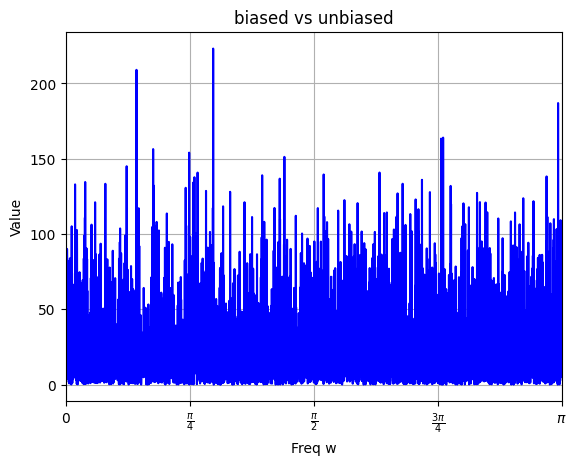

In [494]:
mean = 0
std = 5
noise = np.random.normal(mean, std, 10000) # Ruido blanco gaussiano

p, w = periodogram(noise)

plt.plot(w, p, linestyle='-', color='b')
plt.title('biased vs unbiased')
plt.xlabel('Freq w')
plt.ylabel('Value')
pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)
pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
plt.xticks(pi_ticks, pi_labels)
plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

25.12921507886012
24.865308997573667


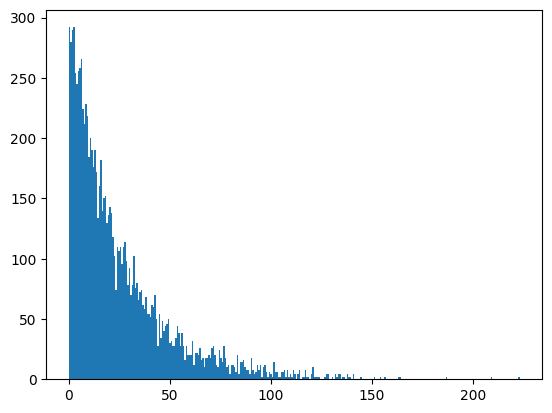

In [495]:
plt.hist(p, bins = 300);
print(np.std(p))
print(np.mean(p))

**NOTAR QUE EL STD DA LO MISMO QUE LO QUE DICE LA TEORIA, AUNQUE NO ES UNA GAUSSIANA**
---
Ahora veamos la performance del biased y unbiased

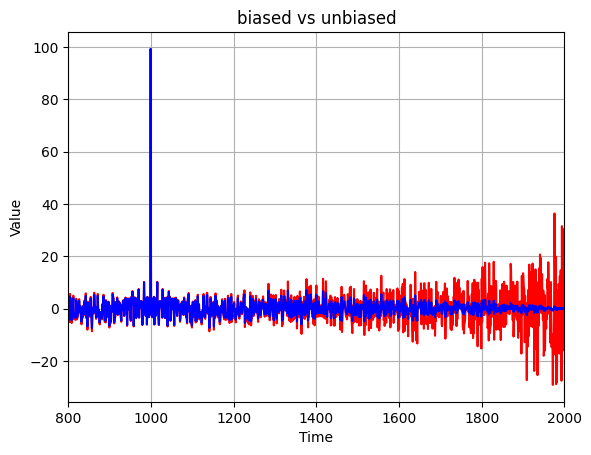

In [223]:
x = biased_autocorr(noise)
y = unbiased_autocorr(noise)
plt.plot(y, linestyle='-', color='r')
plt.plot(x, linestyle='-', color='b')
plt.title('biased vs unbiased')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(800, 2000)
plt.grid(True)
plt.show()

**Notar el efecto del ruido amplicado**

# Periodogram Smoothing

In [496]:
# x: datos de tamaño N
# L: Siendo (L-1) tamaño del lag máximo de autocorrelación i.e. Rxx(l > |L-1|) = 0
# N_FFT: La cantidad de puntos que se usa en la FFT para visualizar el periodograma. Notar que en clase solemos hacerlo con N, pero podemos
# usar un valor mas chico a N para no hacerlo tan pesado al plot, aunque siempre debe ser mas grande que 2L-1 claramente. 
# Elegir N_FFT != N no "cambia" nada, simplemente se interpola con menos puntos
def periodogram_smoothing(x, L, N_FFT):
    N = len(x)
    rxx = biased_autocorr(x) # 2N - 1 de largo
    offset = N - 1 
    rxx = rxx[offset - (L-1) : offset + (L-1) + 1] # autocorr ventaneada o windowed con L
    window = signal.get_window(window="bartlett", Nx=2*L-1, fftbins= False) 
    rxx_windowed = rxx*window

    Rxx = np.abs(fft.fft(rxx_windowed, n = N_FFT)) # (*) ver MARKDOWN ABAJO
    w = fft.fftfreq(N_FFT, d=1.0) * 2 * np.pi
    return Rxx, w


(*) No deberia ser necesario aplicar abs, dado que siempre es positiva la ventana triangular o la de parzen, pero dado que contiene componentes imaginarias el abs debera ser aplicado. La DTFT sobre la triangular no aparece complejos, pero la DFT se puede pensar como un muestreo de la DTFT, pero SHIFTEADO en tiempo, (ver definicion de DFT), este shifteo en tiempo en frecuencia le agrega un fasor complejo, que no afecta el modulo, pero te mete complejos. 

50


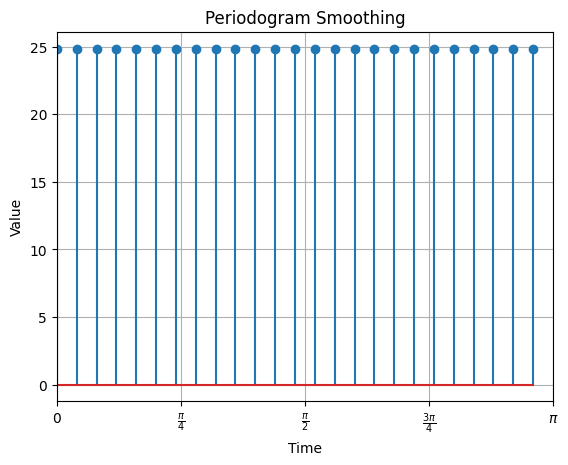

In [498]:
Rxx, w = periodogram_smoothing(noise, 2, 50)
print(len(Rxx))
#plt.plot(rxx)
#plt.plot(window)
plt.stem(w, Rxx)
plt.title('Periodogram Smoothing')

pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)
pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
plt.xticks(pi_ticks, pi_labels)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(0, np.pi)
plt.grid(True)
plt.show()

In [372]:
def pulse(n, M):
    return np.array([1 if (np.abs(nVal) <= (M-1)/2) else 0 for nVal in n])

# Periodogram Averaging

In [499]:
def periodogram_averaging(x, L, D, N_FFT): # procurar que N_FFT > L, aunque creo que si no se cumple la fft es de size L
    N = len(x)
    num_segmentos = int(np.ceil((N - (L-1))/D))
    Rx = np.zeros(N_FFT)
    for i in range(0, num_segmentos):
        x_seg = x[i*D : i*D + L]
        Rx += 1/L * np.abs(fft.fft(x_seg, N_FFT))**2

    Rx = Rx/num_segmentos
    w = fft.fftfreq(N_FFT, d=1.0) * 2 * np.pi
    return Rx, w

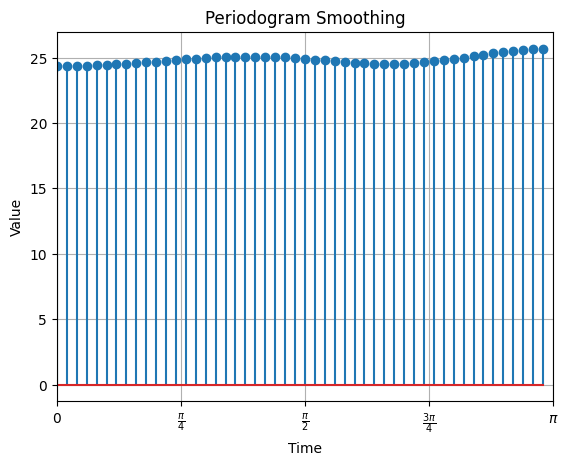

In [500]:
Rxx, w = periodogram_averaging(noise, 5, 5, 100)

plt.stem(w, Rxx)
plt.title('Periodogram Smoothing')

pi_ticks = np.arange(-np.pi, np.pi + 0.1, np.pi/4)
pi_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{3\pi}{2}$',r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$']
plt.xticks(pi_ticks, pi_labels)

plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(0, np.pi)
plt.grid(True)
plt.show()